<a href="https://colab.research.google.com/github/KilluJ/nlp-projects/blob/main/Rating-Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#preprocess the .json file
import pandas as pd

df = pd.read_json('reviews.json', lines=True)
data = df[["reviewText", "overall"]]

In [2]:
#equally split the train set and the test set
train, test = data[:len(data)//2], data[len(data)//2:]

In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [4]:
#make new directory to store .text files for each review under each rating group
train_dir, test_dir = './train', './test'
os.mkdir(train_dir)
os.mkdir(test_dir)

In [5]:
#make new directory for each rating group
for k in set(train["overall"]):
    os.mkdir(os.path.join(train_dir, str(k)))
    os.mkdir(os.path.join(test_dir, str(k)))

In [6]:
#convert each review to a .text file for training set
for index, row in train.iterrows():
    curdir = os.path.join(train_dir, str(row['overall']))
    curname = str(row['overall']) + str(index) + '.txt'
    f = open(os.path.join(curdir, curname), 'w', encoding='utf-8')
    f.write(row['reviewText'])
    f.close()

In [7]:
#convert each review to a .text file for testing set
for index, row in test.iterrows():
    curdir = os.path.join(test_dir, str(row['overall']))
    curname = str(row['overall']) + str(index) + '.txt'
    f = open(os.path.join(curdir, curname), 'w', encoding='utf-8')
    f.write(row['reviewText'])
    f.close()

In [8]:
#check for a random review rated 1/5
sample_file = os.path.join(train_dir, '1/1100261.txt')
with open(sample_file) as f:
  print(f.read())

Maybe this works for schrader valves and beach balls, but it is utterly useless for presta valves. After 30 frustrating minutes of trying to air up a tube on my bike, I returned it to the store, bought a Giant Control Tower T1 pump at my local bike shop, and I was back in business.


In [9]:
#preparing input for training set
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    './train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 148168 files belonging to 5 classes.
Using 118535 files for training.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"It works.  I personally like having the wire brush part separate from the rope as opposed to the other rope cleaner that has them combined (although I haven't ever tried the other one so don't take me too seriously).  This thing is easy to use and seems like it should be gentle on the gun.  I have only used it a couple of times so far so reliability is TBD (seems like the pull cord could separate from the fat rope cleaner over time)."
Label 4
Review b'Breathe good and very comfortable. Im between a small and medium, these fit good. Great for warm weather. . .'
Label 3
Review b"I purchased the X-Large size and a Small size.  I got the small one to use for quick clean ups, or as a towel to pat dry my face etc, and the large one for showering AND for to use as a blanket while on an airplane.  I always use the airline's blankets, but since some started charging and they may not be that sanitary, I plan to use the Sea to Summit X-Large size one as a blanket.  I love how they pack a

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])
print("Label 4 corresponds to", raw_train_ds.class_names[4])

Label 0 corresponds to 1
Label 1 corresponds to 2
Label 2 corresponds to 3
Label 3 corresponds to 4
Label 4 corresponds to 5


In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    './train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 148168 files belonging to 5 classes.
Using 29633 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    './test',
    batch_size=batch_size)

Found 148169 files belonging to 5 classes.


In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [15]:
#vectorize the input
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'These targets take a beating and keep on going.  I have shot 9mm, .40, .45acp, .44mag, 7.62x39 and .308..... No problems.  This is a good to great item, we as a family shoot and its a great way to add a little fun to our family time.. just wish shells were cheaper.. im just glad this unit is and was sold as said.  I foresee lot more good time in the future', shape=(), dtype=string)
Label 5
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  32,  820,  147,    3, 2535,    4,  124,   14,  171,    5,   19,
         480,  963,  642, 5061,    1, 6493,    4, 2277,   57,  363,   11,
           8,    3,   37,    6,   33,  254,  137,   21,    3,  997,  459,
           4,   26,    3,   33,  118,    6,  426,    3,   62,  563,    6,
         303,  997,   72,   35,  377, 1002,  129,  622,   91,   35,  687,
          11,  506,    8,    4,   23, 1163,   21,  315,    5, 8416,  146,
          49,   37,   72,   12,    2, 1184,    0,    0,    0,    0,    0,
   

In [19]:
print("820 ---> ",vectorize_layer.get_vocabulary()[820])
print("147 ---> ",vectorize_layer.get_vocabulary()[147])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

820 --->  targets
147 --->  take
Vocabulary size: 10000


In [20]:
#do the final vectorization for each data group
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
#define our model
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(5, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 160085 (625.33 KB)
Trainable params: 160085 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [23]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',
              metrics=['accuracy'])

In [24]:
#start training
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
3705/3705 [==============================] - 106s 28ms/step - loss: 1.0288 - accuracy: 0.6378 - val_loss: 0.9731 - val_accuracy: 0.6430
Epoch 2/10
3705/3705 [==============================] - 17s 5ms/step - loss: 0.9283 - accuracy: 0.6486 - val_loss: 0.8979 - val_accuracy: 0.6540
Epoch 3/10
3705/3705 [==============================] - 16s 4ms/step - loss: 0.8693 - accuracy: 0.6616 - val_loss: 0.8615 - val_accuracy: 0.6633
Epoch 4/10
3705/3705 [==============================] - 18s 5ms/step - loss: 0.8340 - accuracy: 0.6725 - val_loss: 0.8381 - val_accuracy: 0.6746
Epoch 5/10
3705/3705 [==============================] - 17s 5ms/step - loss: 0.8098 - accuracy: 0.6807 - val_loss: 0.8257 - val_accuracy: 0.6812
Epoch 6/10
3705/3705 [==============================] - 16s 4ms/step - loss: 0.7934 - accuracy: 0.6870 - val_loss: 0.8182 - val_accuracy: 0.6835
Epoch 7/10
3705/3705 [==============================] - 16s 4ms/step - loss: 0.7832 - accuracy: 0.6907 - val_loss: 0.8143 - val_

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

4631/4631 [==============================] - 22s 5ms/step - loss: 0.8170 - accuracy: 0.6810
Loss:  0.8170382380485535
Accuracy:  0.6810331344604492


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

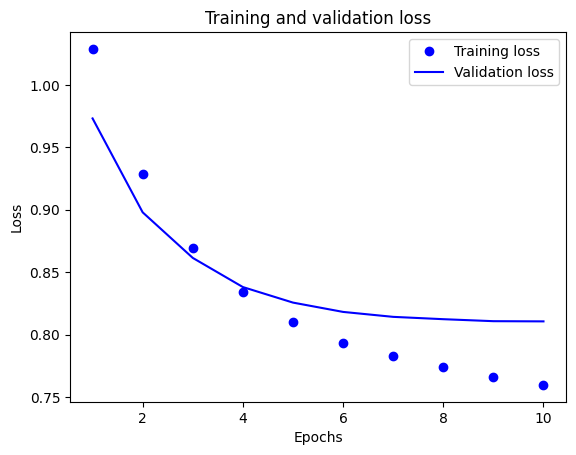

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

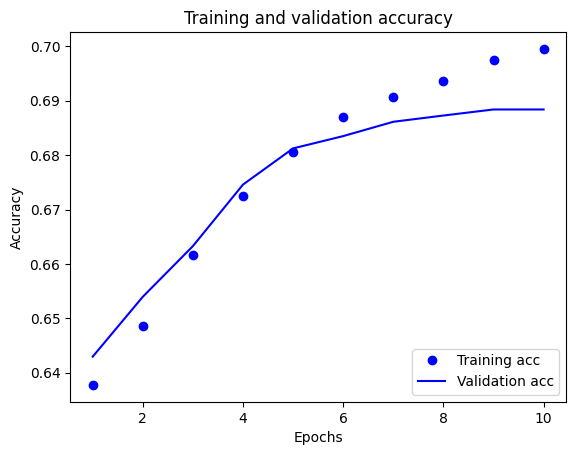

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

4631/4631 [==============================] - 28s 6ms/step - loss: 1.2827 - accuracy: 0.6810
0.6810331344604492


In [31]:
#the examples are randomwly picked from the 'summary' section of the original .json file
examples = [
  "Seems okay.", #3
  "Love love love!", #5
  "Great for my device", #4
    "perfect.", #5
    "do not waste your money.", #1
    "try it yourself.", #3
]

[int(tf.math.argmax(l)) + 1 for l in export_model.predict(examples)]

1/1 [==============================] - 0s 54ms/step


[3, 5, 5, 5, 1, 5]